# Laboratorium 3 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

In [2]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud
from copy import copy

In [3]:
PATH = '/content/drive/MyDrive/socialmediadata-beeradvocate/data/beer_reviews.csv'
SCORE_THRESHOLD = 4 # recenzje z co najmniej taka ocena wezmiemy pod uwage
VECTOR_SIZE = 20 # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10 # na ile segmentow chcemy podzielic populacje uzytkownikow

In [4]:
# wczytujemy dane

def parse_headers(column_names):
    beer_id_column =  column_names.index('beer_beerid')
    beer_style_column = column_names.index('beer_style')
    user_id_column =  column_names.index('review_profilename')
    score_column =  column_names.index('review_overall')
    return beer_id_column, beer_style_column, user_id_column, score_column

def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return line[beer_id_column], line[beer_style_column], line[user_id_column], float(line[score_column])

def read_and_parse_reviews(path, score_threshold):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))

        users_favourite_beers = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            if score >= score_threshold:
                users_favourite_beers[user_id].append(beer_id)

    return users_favourite_beers

def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, 'r', 'UTF-8') as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(next(datareader))
        beer_styles = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(review, beer_id_column, beer_style_column, user_id_column, score_column)
            beer_styles[beer_id] = beer_style
        return beer_styles

# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers = read_and_parse_reviews(PATH, SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

In [5]:
users_favourite_beers

Output hidden; open in https://colab.research.google.com to view.

In [6]:
beer_styles

{'47986': 'Hefeweizen',
 '48213': 'English Strong Ale',
 '48215': 'Foreign / Export Stout',
 '47969': 'German Pilsener',
 '64883': 'American Double / Imperial IPA',
 '52159': 'Herbed / Spiced Beer',
 '436': 'Light Lager',
 '10789': 'Oatmeal Stout',
 '12386': 'American Pale Lager',
 '58046': 'Rauchbier',
 '25414': 'American Pale Ale (APA)',
 '10788': 'American Porter',
 '58920': 'Belgian Strong Dark Ale',
 '10784': 'American IPA',
 '21241': 'American Stout',
 '20818': 'Russian Imperial Stout',
 '10786': 'American Amber / Red Ale',
 '10794': 'American Strong Ale',
 '54330': 'Märzen / Oktoberfest',
 '20817': 'American Adjunct Lager',
 '61427': 'American Blonde Ale',
 '3386': 'Euro Pale Lager',
 '55097': 'English Brown Ale',
 '2780': 'American Porter',
 '20689': 'Scotch Ale / Wee Heavy',
 '2725': 'American IPA',
 '33624': 'American IPA',
 '56071': 'American IPA',
 '10785': 'American Amber / Red Ale',
 '76963': 'American Porter',
 '23290': 'American Amber / Red Ale',
 '49803': 'German Pilse

## Część 2. - osadzenia użytkowników

In [7]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model = Word2Vec(sentences=users_favourite_beers.values(), vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [8]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow

def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    # inicjalizujemy wektor zerami
    v = np.zeros(vector_size)

    # iterujemy po liscie user_favourite_beers, odczytujemy z modelu wektor reprezentujacy kazde piwo i dodajemy do wektora
    #   uzyj: model.wv[beer_id]
    # ...
    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]

    # normalizujemy wektor - dzielimy kazda wspolrzedna przez liczbe piw
    # ...
    v /= len(user_favourite_beers)

    return v


def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    mean_users_vectors = {}

    mean_users_vectors = {
        user_id: get_mean_vector_for_user(beers, model, vector_size)
        for user_id, beers in users_favourite_beers.items()
    }

    return mean_users_vectors

user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

In [9]:
user_vectors

{'johnmichaelsen': array([ 0.54854242,  0.31338565, -0.17629479,  0.38213503, -0.2894543 ,
        -0.56278803, -0.54254471,  1.14308545, -0.10504658,  0.76447274,
         0.27958451, -0.37911272,  0.09908236,  0.56842637,  0.73914301,
         0.5877133 ,  0.35527548, -1.14571987, -0.66400231, -1.04129509]),
 'LordAdmNelson': array([ 0.94359795,  0.32674273, -0.53922264,  0.63556729, -0.70208671,
        -0.82757378, -0.77430686,  1.57085635,  0.14680379,  1.27902061,
        -0.34156018, -0.63980954,  0.59577879,  0.98286883,  1.27817475,
         1.18745982,  0.56488422, -1.73314782, -1.02851338, -2.24404244]),
 'augustgarage': array([ 0.82929883,  0.44922313, -0.1929486 ,  0.53786051, -0.30388432,
        -0.69418896, -0.7138996 ,  1.332234  ,  0.03577229,  0.9276945 ,
         0.5177931 , -0.44437095,  0.26042963,  0.67699991,  0.88383702,
         0.80310239,  0.35122487, -1.4075041 , -0.83133089, -1.43613018]),
 'MadeInOregon': array([ 0.5658339 ,  0.04520293, -0.58670121,  1.1

## Część 3. - klasteryzacja

In [10]:
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, np K-means, Agglomerative, Birch, ...

def get_users_segmentation(user_vectors, vector_size, segments_count, clustering_algorithm):
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = list(user_vectors.keys())
    vectors = list(user_vectors.values())

    # zamieniamy liste wektorow w macierz
    users_array = np.stack(vectors, axis=0)
    # zaimplementuj wsparcie dla co najmniej jednego algorytmu wiecej
    if clustering_algorithm == 'agglomerative':
        clustering = AgglomerativeClustering(n_clusters=segments_count).fit_predict(users_array)
        # clustering to lista przypisanych klastrow - i-ty element to klaster, do ktorego nalezy i-ty wektor
    elif clustering_algorithm == 'kmeans':
        clustering = KMeans(n_clusters=segments_count).fit_predict(users_array)
    elif clustering_algorithm == 'birch':
        clustering = Birch(n_clusters=segments_count).fit_predict(users_array)

    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster
    # segmentation -> do jakiego clustra ~ grupy zainteresowan nalezy dany uzytkownik
    segmentation = {user_id: cluster for user_id, cluster in zip(users, clustering)}

    return segmentation


segmentation = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'agglomerative')
segmentation_kmn = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'kmeans')
segmentation_bir = get_users_segmentation(user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, 'birch')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation):
    res = {cluster : 0 for cluster in segmentation.values()}
    for cluster in segmentation.values():
        res[cluster] += 1

    # res zawiera mapping cluster -> licznosc clustra
    # res zawiera licznosc clustrow czyli ile uzytkownikow trafilo do danego clustra ~ grupy zainteresowan
    return res

In [12]:
get_segment_sizes(segmentation)

{1: 16113,
 7: 2851,
 9: 2581,
 0: 2104,
 6: 1161,
 4: 898,
 2: 1892,
 5: 1145,
 3: 806,
 8: 735}

In [13]:
get_segment_sizes(segmentation_kmn)

{0: 6329,
 4: 11374,
 2: 3520,
 3: 1518,
 9: 1521,
 6: 1166,
 7: 827,
 8: 1790,
 5: 909,
 1: 1332}

In [14]:
get_segment_sizes(segmentation_bir)

{0: 10286,
 9: 3081,
 8: 2942,
 1: 2668,
 4: 2466,
 5: 2188,
 7: 2377,
 2: 1264,
 3: 1848,
 6: 1166}

In [15]:
# obliczamy metryke jakosci segmentacji
# metryka przyjmuje wartosci [-1, 1] - im wiecej, tym lepiej
users, user_vectors_list = zip(*user_vectors.items())
segments_list = [segmentation[u] for u in users]

mean_silhouette = silhouette_score(user_vectors_list, segments_list, metric='euclidean')
per_sample_silhouettes = silhouette_samples(user_vectors_list, segments_list, metric='euclidean')

segments_list_kmn = [segmentation_kmn[u] for u in users]
mean_silhouette_kmn = silhouette_score(user_vectors_list, segments_list_kmn, metric='euclidean')
per_sample_silhouettes_kmn = silhouette_samples(user_vectors_list, segments_list_kmn, metric='euclidean')

segments_list_bir = [segmentation_bir[u] for u in users]
mean_silhouette_bir = silhouette_score(user_vectors_list, segments_list_bir, metric='euclidean')
per_sample_silhouettes_bir = silhouette_samples(user_vectors_list, segments_list_bir, metric='euclidean')

In [16]:
# rysujemy wykres
def plot_histogram(values, mean_value):
    plt.hist(values, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_value, linestyle='dashed', linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height*1.05, 'Mean: {:.3f}'.format(mean_value))
    plt.show()

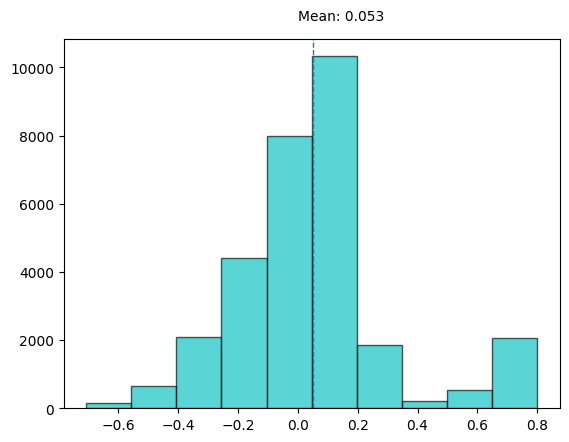

In [17]:
plot_histogram(per_sample_silhouettes, mean_silhouette)

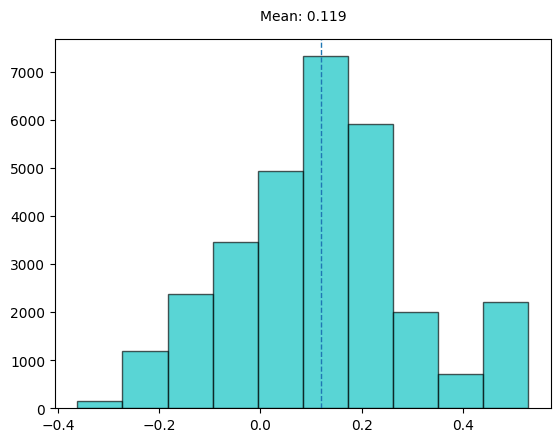

In [18]:
plot_histogram(per_sample_silhouettes_kmn, mean_silhouette_kmn)

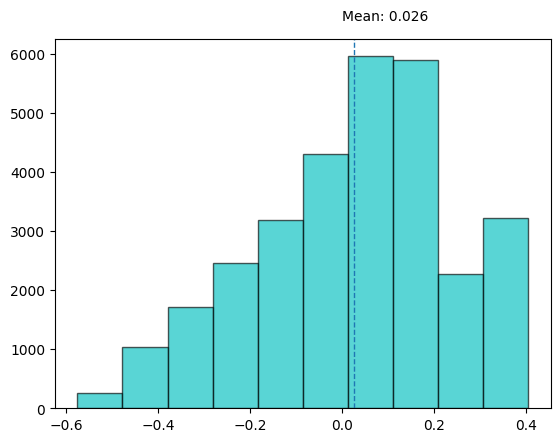

In [19]:
plot_histogram(per_sample_silhouettes_bir, mean_silhouette_bir)

## Część 4. - opisy segmentów

In [20]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal

def get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, segments_count):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]

    for user, beers in users_favourite_beers.items():  # user -> lista ulubionych piw
        for beer in beers:
            beer_styles_per_segment[segmentation[user]][beer_styles[beer]] += 1

    return beer_styles_per_segment

def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)

    for segment in beer_styles_per_segment.keys():
        for style in beer_styles_per_segment[segment]:
            total_popularity[style] += beer_styles_per_segment[segment][style]

    return total_popularity

per_segment_styles_popularity = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation, SEGMENTS_COUNT)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

per_segment_styles_popularity_kmn = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation_kmn, SEGMENTS_COUNT)
total_styles_popularity_kmn = get_total_styles_popularity(per_segment_styles_popularity_kmn)

per_segment_styles_popularity_bir = get_per_segment_styles_popularity(users_favourite_beers, beer_styles, segmentation_bir, SEGMENTS_COUNT)
total_styles_popularity_bir = get_total_styles_popularity(per_segment_styles_popularity_bir)

In [21]:
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
# oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
# dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}

def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    result = {}

    for segment in per_segment_styles_popularity.keys():
        # sortuj słownik popularności styli po wartościach (popularności); wybierz pierwsze N i stwórz z tego słownik
        result[segment] = dict(
            sorted(per_segment_styles_popularity[segment].items(), key=lambda x: x[1], reverse=True)[:N])

    return result

def most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, N):
    result = {}
    # Stwórz kopię popularnosc_styli_na_segment, aby nie modyfikować oryginalnego słownika.
    per_segment_distinctive_styles_popularity = copy(per_segment_styles_popularity)

    for segment in per_segment_styles_popularity.keys():
        for style in per_segment_styles_popularity[segment].keys():
            # Oblicz popularność względną, dzieląc popularność segmentu przez łączną popularność.
            per_segment_distinctive_styles_popularity[segment][style] /= total_styles_popularity[style]

    for segment in per_segment_distinctive_styles_popularity.keys():
        # Posortuj style według popularności względnej malejąco i wybierz pierwsze N.
        result[segment] = dict(
            sorted(per_segment_distinctive_styles_popularity[segment].items(), key=lambda x: x[1], reverse=True)[:N])

    return result

top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(total_styles_popularity, per_segment_styles_popularity, top_N)

most_popular_kmn = most_popular_styles_per_segment(per_segment_styles_popularity_kmn, top_N)
most_distinctive_kmn = most_distinctive_styles_per_segment(total_styles_popularity_kmn, per_segment_styles_popularity_kmn, top_N)

most_popular_bir = most_popular_styles_per_segment(per_segment_styles_popularity_bir, top_N)
most_distinctive_bir = most_distinctive_styles_per_segment(total_styles_popularity_bir, per_segment_styles_popularity_bir, top_N)

In [22]:
most_popular

{0: {'American IPA': 653,
  'American Double / Imperial IPA': 486,
  'Russian Imperial Stout': 383,
  'American Amber / Red Ale': 300,
  'American Double / Imperial Stout': 266,
  'American Porter': 260,
  'Oatmeal Stout': 254,
  'American Pale Ale (APA)': 235,
  'American Stout': 180,
  'Belgian Strong Dark Ale': 179,
  'Tripel': 179,
  'Quadrupel (Quad)': 163,
  'Hefeweizen': 160,
  'American Brown Ale': 158,
  'Maibock / Helles Bock': 146,
  'American Strong Ale': 134,
  'English Brown Ale': 120,
  'Dubbel': 119,
  'Doppelbock': 116,
  'Fruit / Vegetable Beer': 113,
  'Witbier': 110,
  'Belgian Strong Pale Ale': 107,
  'American Pale Wheat Ale': 100,
  'Saison / Farmhouse Ale': 91,
  'American Barleywine': 89,
  'Milk / Sweet Stout': 88,
  'English Porter': 87,
  'English Pale Ale': 84,
  'Winter Warmer': 84,
  'Märzen / Oktoberfest': 80,
  'English India Pale Ale (IPA)': 76,
  'German Pilsener': 76,
  'Belgian Pale Ale': 68,
  'Irish Dry Stout': 60,
  'Pumpkin Ale': 58,
  'Scotch A

In [23]:
most_distinctive

{0: {'Maibock / Helles Bock': 0.021958189201383666,
  'Oatmeal Stout': 0.01972509124796148,
  'Chile Beer': 0.011990407673860911,
  'Quadrupel (Quad)': 0.01181159420289855,
  'English Porter': 0.011250484934695461,
  'American Stout': 0.011126908573901218,
  'American Amber / Red Ale': 0.010988608475880004,
  'Bière de Champagne / Bière Brut': 0.010810810810810811,
  'English Brown Ale': 0.0107095046854083,
  'Vienna Lager': 0.01044689495066744,
  'Milk / Sweet Stout': 0.009834599910594547,
  'American Brown Ale': 0.009585052171802961,
  'Russian Imperial Stout': 0.009332813489936156,
  'Tripel': 0.008688055137601321,
  'Dubbel': 0.008628190255220417,
  'Hefeweizen': 0.008442826236082529,
  'English India Pale Ale (IPA)': 0.008356239692138537,
  'American Pale Wheat Ale': 0.008262414277451871,
  'American Double / Imperial Pilsner': 0.008224617129892229,
  'Fruit / Vegetable Beer': 0.008175964112582302,
  'Doppelbock': 0.008141493542953397,
  'Euro Pale Lager': 0.007965686274509803,
  

## Część 5. - wizualizacja

In [24]:
# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
# zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami

def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    wordcloud1 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

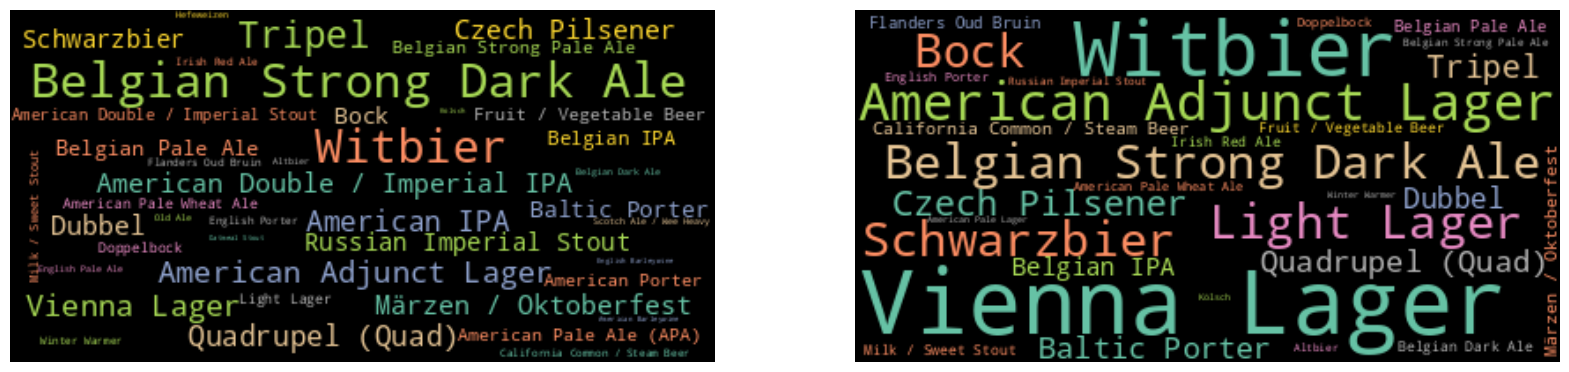

In [25]:
visualise_styles(most_popular, most_distinctive, 3)

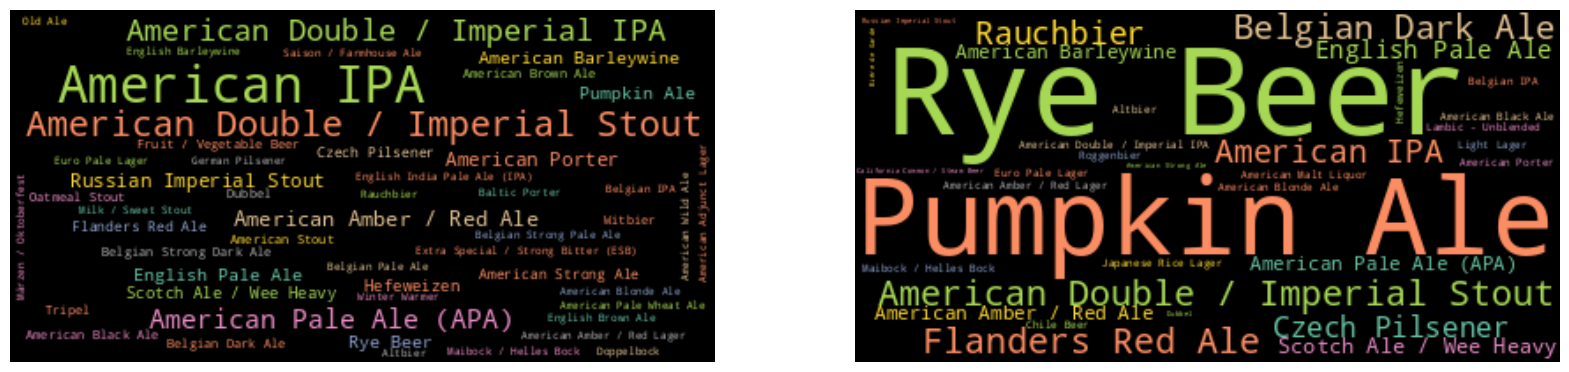

In [26]:
visualise_styles(most_popular_kmn, most_distinctive_kmn, 3)

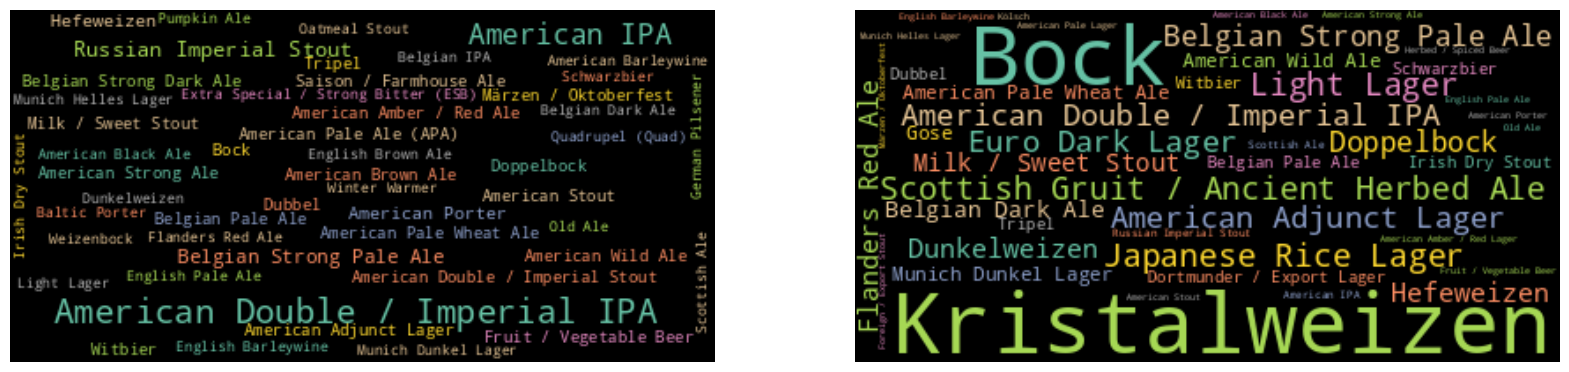

In [27]:
visualise_styles(most_popular_bir, most_distinctive_bir, 3)